In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [17]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset(
    data_root='../data/BIOQIC',
    data_name='phantom',
    xyz_slice='2D',
    frequency=100
)
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Loading ../data/BIOQIC/phantom_elastogram.npy
     <class 'numpy.ndarray'> (8, 128, 80, 25) complex128
Loading ../data/BIOQIC/phantom_regions.npy
     <class 'numpy.ndarray'> (128, 80, 25) int64
Preprocessing data
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, component: 2, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 100.0
  * component       (component) <U1 'z' 'y'
    z               float64 0.0
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y           

<xarray.Dataset>
Dimensions:         (frequency: 1, component: 2, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 100.0
  * component       (component) <U1 'z' 'y'
    z               float64 0.0
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y               (y) float64 0.0 0.0015 0.003 0.0045 ... 0.1155 0.117 0.1185
    spatial_region  (x, y) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
Data variables:
    a               (frequency, x, y, component) float64 0.0 0.0 ... 56.62 60.25
    u               (frequency, x, y, component) complex128 (73.8925375108920...
    mu              (frequency, x, y) complex128 0j 0j 0j 0j 0j ... 0j 0j 0j 0j
    Ku              (frequency, x, y, component) complex128 (220.479819613789...
    Lu              (frequency, x, y, component) complex128 (56062043.9181708...
    Mu              (frequency, x, y) complex128 (593.6465741453834+831.47112...

<IPython.core.display.Javascript object>


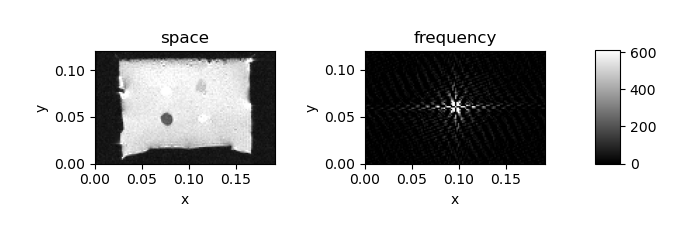

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


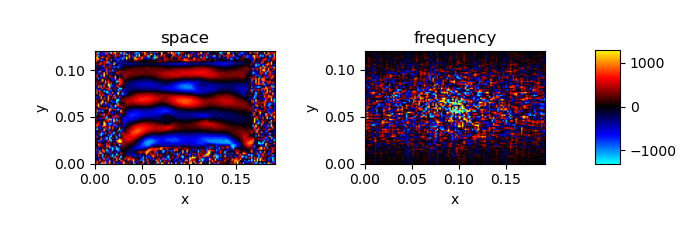

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


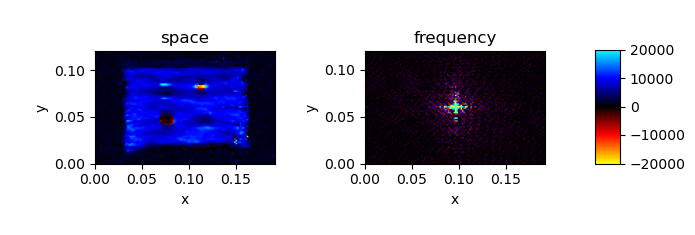

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


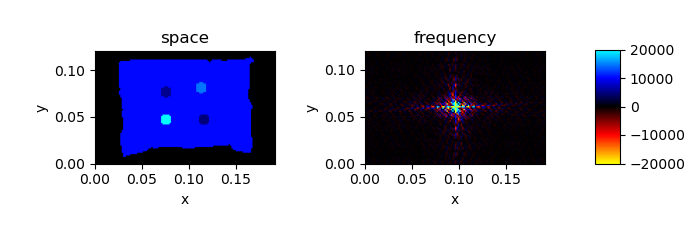

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

In [18]:
%autoreload

# configure color maps
anat_kws = mre_pinn.visual.get_color_kws(data.a)
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

# display true wave field and elastogram
y = 'y' if 'y' in data.field.spatial_dims else None
hue = None if 'y' in data.field.spatial_dims else 'part'
mre_pinn.visual.XArrayViewer(data.a,  col='domain', hue=None, ax_width=2, **anat_kws)
mre_pinn.visual.XArrayViewer(data.u,  col='domain', hue=None, ax_width=2, **wave_kws)
#mre_pinn.visual.XArrayViewer(data.Lu, col='domain', y=y, hue=None, ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), col='domain', hue=None, ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), col='domain', hue=None, ax_width=2, **elast_kws)

In [29]:
%autoreload

net = mre_pinn.pinn.ParallelPINN(
    n_inputs=[data.field.n_spatial_dims + 1, data.field.n_spatial_dims],
    n_outputs=[data.field.n_spatial_dims, 1],
    omega0=1,
    n_layers=5,
    n_hidden=128,
    activ_fn='s',
    dense=True,
    polar=True,
    conditional=True,
    dtype=torch.float32
)
net

ParallelPINN(
  (net0): PINN(
    (input_scaler): InputScaler()
    (linear0): Linear(in_features=5, out_features=128, bias=True)
    (linear1): Linear(in_features=133, out_features=128, bias=True)
    (linear2): Linear(in_features=261, out_features=128, bias=True)
    (linear3): Linear(in_features=389, out_features=128, bias=True)
    (linear4): Linear(in_features=517, out_features=4, bias=True)
    (output_scaler): OutputScaler()
  )
  (net1): PINN(
    (input_scaler): InputScaler()
    (linear0): Linear(in_features=5, out_features=128, bias=True)
    (linear1): Linear(in_features=133, out_features=128, bias=True)
    (linear2): Linear(in_features=261, out_features=128, bias=True)
    (linear3): Linear(in_features=389, out_features=128, bias=True)
    (linear4): Linear(in_features=517, out_features=2, bias=True)
    (output_scaler): OutputScaler()
  )
)

In [30]:
%autoreload
pde = mre_pinn.pde.WaveEquation.from_name('hetero', detach=True)
pde

Compiling model...
'compile' took 0.000206 s

Training model...



<IPython.core.display.Javascript object>


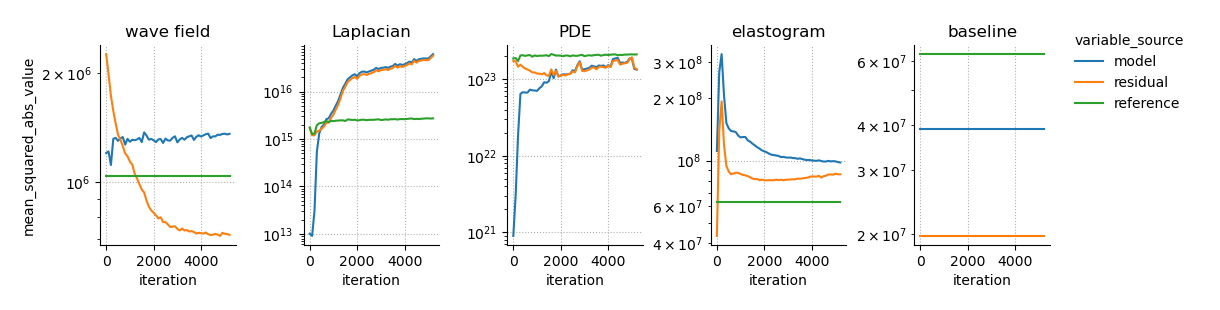

<IPython.core.display.Javascript object>


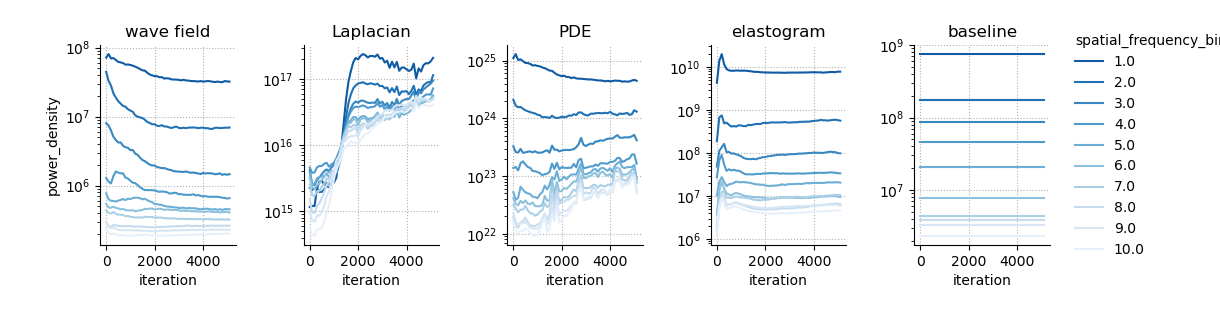

<IPython.core.display.Javascript object>


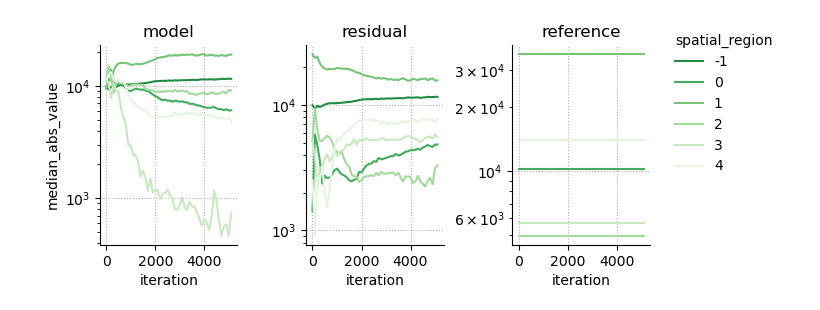

<IPython.core.display.Javascript object>


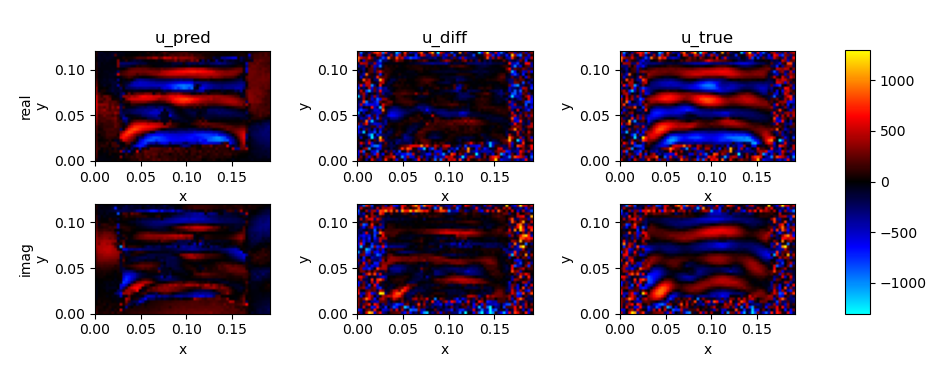

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


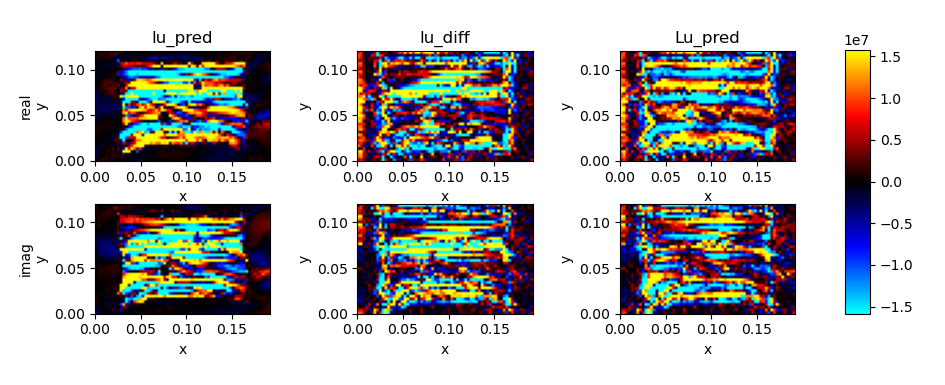

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


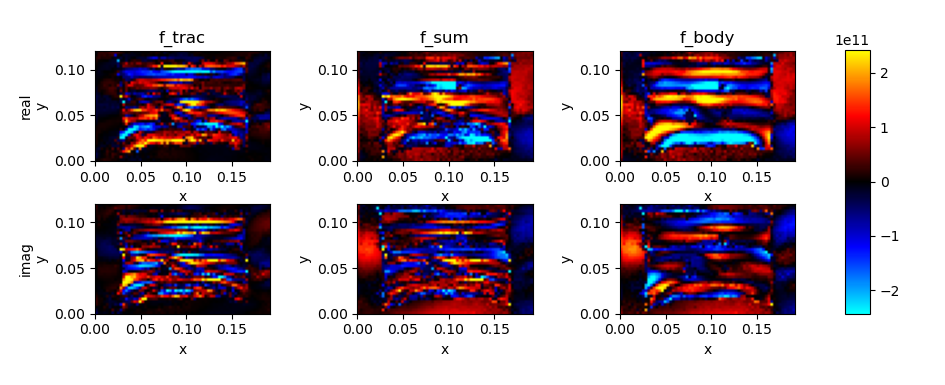

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


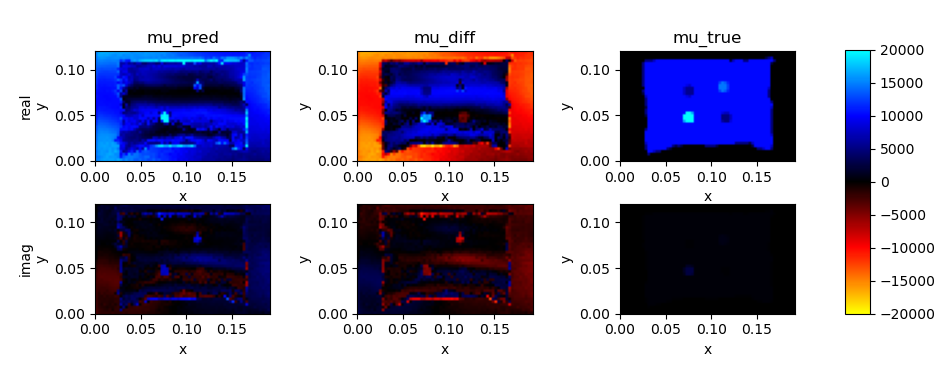

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


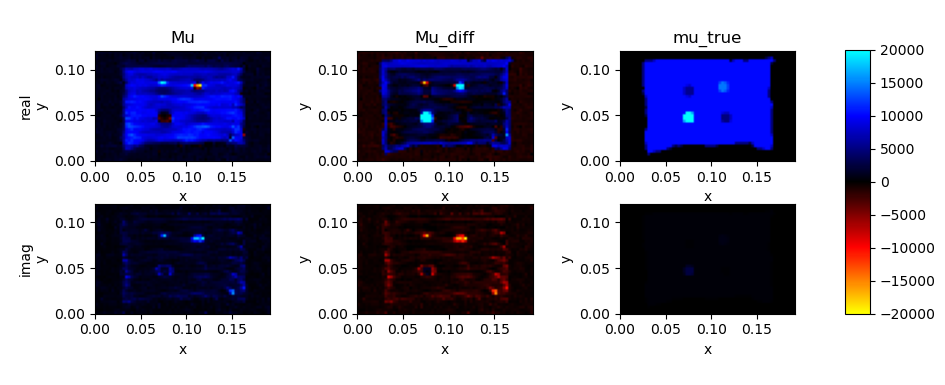

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 35.04%
Time spent testing: 28.55%
Time spent testing: 26.06%
Time spent testing: 24.68%
Time spent testing: 23.85%
Time spent testing: 23.32%
Time spent testing: 22.92%
Time spent testing: 22.61%
Time spent testing: 22.38%
Time spent testing: 22.22%
Time spent testing: 22.08%
Time spent testing: 22.31%
Time spent testing: 22.20%
Time spent testing: 22.15%
Time spent testing: 22.08%
Time spent testing: 22.01%
Time spent testing: 21.97%
Time spent testing: 21.92%
Time spent testing: 21.89%
Time spent testing: 21.85%
Time spent testing: 21.83%
Time spent testing: 21.82%
Time spent testing: 21.80%
Time spent testing: 21.79%
Time spent testing: 21.92%
Time spent testing: 21.91%
Time spent testing: 21.90%
Time spent testing: 21.89%
Time spent testing: 21.88%
Time spent testing: 21.87%
Time spent testing: 21.86%
Time spent testing: 21.85%
Time spent testing: 21.85%
Time spent testing: 21.84%
Time spent testing: 21.84%
Time spent testing: 21.83%
Time spent testing: 21.93%
T

In [ ]:
%autoreload

model = mre_pinn.training.PINNModel(data, net, pde, batch_size=128)
model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1, 1e-8],
    loss=mre_pinn.training.standardized_msae_loss_fn(data.u.values)
)
deepxde.display.training_display = mre_pinn.training.SummaryDisplay()

test_eval = mre_pinn.testing.TestEvaluator(
    test_data, model, batch_size=None, test_every=100, save_every=1000, interact=True
)
try:
    model.train(50000, display_every=10, callbacks=[test_eval])
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)